In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''') 

# <font color="#E56717">IOBS & IBA Project Update</font>

# <font color="#E56717">October 2016</font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
#print(preDouble)

In [3]:
df = pd.read_pickle('dfpedsfFirsts.pickle')

# <font color="#E56717">First order of business is to identify all the patients in the SEER-Medicare data who have revceived PBT</font>

<span style="font-size:1.5em;">The relevant HCPCS codes are:</span>

* <span style="font-size:1.5em;">77520 - Proton trmt simple w/o comp</span>
* <span style="font-size:1.5em;">77522 - Proton trmt simle w/comp</span>
* <span style="font-size:1.5em;">77523 - Proton trmt intermediate</span>
* <span style="font-size:1.5em;">77525 - Proton treatment complex</span>

# <font color="#E56717">Use the Outpatient Claims and Carrier Claims files</font>

* <span style="font-size:1.5em;">218 Outpatient Claims files</span>
* <span style="font-size:1.5em;">207 Carrier Claims files</span>

<span style="font-size:1.5em;">Loop through all of these files and capture the set of all the patient_id s corresponding to teh PBT HCPCS codes</span>

## <font color="#E56717">Result:</font>

* <span style="font-size:1.5em;">1605 unique PBT patients appear in the claims files for claims in years 2006-2013</span>

In [4]:
mask = (df['srvm1'] != 9999)
dfall = df[mask]

In [5]:
geomask = (dfall['elevation_1'] != dfall['FIPScombo_1']) 

dfall = dfall[geomask].copy()

In [6]:
dfall['elevation_1'].replace('99999',np.nan,inplace=True)
dfall['elevation_2'].replace('99999',np.nan,inplace=True)
dfall['elevation_3'].replace('99999',np.nan,inplace=True)

dfall['lat_1'].replace('99999',np.nan,inplace=True)
dfall['lat_2'].replace('99999',np.nan,inplace=True)
dfall['lat_3'].replace('99999',np.nan,inplace=True)

dfall['lng_1'].replace('99999',np.nan,inplace=True)
dfall['lng_2'].replace('99999',np.nan,inplace=True)
dfall['lng_3'].replace('99999',np.nan,inplace=True)

dfall['elevation_1'] = dfall['elevation_1'].astype('float')
dfall['elevation_2'] = dfall['elevation_2'].astype('float')
dfall['elevation_3'] = dfall['elevation_3'].astype('float')

dfall['lat_1'] = dfall['lat_1'].astype('float')
dfall['lat_2'] = dfall['lat_2'].astype('float')
dfall['lat_3'] = dfall['lat_3'].astype('float')

dfall['lng_1'] = dfall['lng_1'].astype('float')
dfall['lng_2'] = dfall['lng_2'].astype('float')
dfall['lng_3'] = dfall['lng_3'].astype('float')

In [15]:
import pickle
fileObject = open('patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_outsaf = list(set.union(*b))

In [16]:
import pickle
fileObject = open('patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_nch = list(set.union(*b))

In [9]:
bigtreatmentindices = list(set(treatmentindices_nch+treatmentindices_outsaf))

dfall.set_index('patient_id', inplace=True,drop=False)

allindices = dfall.index

In [10]:
bigtreatmentset = set(bigtreatmentindices)
allset = set(allindices)


alltreatmentindices = list(allset.intersection(bigtreatmentset))

treatmentindices = alltreatmentindices
#len(treatmentindices)

In [12]:
len(set(treatmentindices))

1605

# <font color="#E56717">Next step is to identify the patients in the SEER-Medicare data who have received any other form of RT</font>

<span style="font-size:1.5em;">Identifying these patients via the SEER data alone proved problematic; half of these patients did not have RT code signatures in the Medicare data.</span>

## <font color="#E56717">Use the following RT treatment delivery codes:</font>

<span style="font-size:1.3em;">['77401','77402','77403','77404','77405','77406','77407','77408','77409','77410','77411','77412','77413',
 '77414','77415','77416','77417','77418','77419','77420','77421','77422','77423','77424','77425','77521',
 '77524','77750','77751','77752','77753','77754','77755','77756','77757','77758','77759','77760','77761',
 '77762','77763','77764','77765','77766','77767','77768','77769','77770','77771','77772','77773','77774',
 '77775','77776','77777','77778','77779','77780','77781','77782','77783','77784','77785','77786','77787',
 '77788','77789','77790','77791','77792','77793','77794','77795','77796','77797','77798','77799','G0173',
 'G0251','G0256','G0261','G0339','G0340']</span>

In [17]:
import pickle
fileObject = open('control_patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_outsaf = list(set.union(*b))

In [18]:
import pickle
fileObject = open('control_patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_nch = list(set.union(*b))

In [19]:
bigcontrolindices = list(set(controlindices_nch+controlindices_outsaf))

In [20]:
bigcontrolset = set(bigcontrolindices)
allset = set(allindices)


allcontrolindices = list(allset.intersection(bigcontrolset))

controlindices = allcontrolindices
#len(treatmentindices)

In [21]:
len(controlindices)

177154

# <font color="#E56717">175878 unique patients had those RT treatment delivery codes (and did not have any PBT codes)</font>


In [22]:
len(treatmentindices)

1605

In [23]:
purecontrolindices = list(set(controlindices) - set(treatmentindices))
len(purecontrolindices)

175878

In [24]:
len(controlindices) - len(purecontrolindices)

1276

# <font color="#E56717">Now use the pedsf files to perform patient matching, using the patient_id s found above</font>

<span style="font-size:1.5em;">List of pedsf files (contains SEER diagnosis year dates 2006-2011):</span>

* pedsf.nasopharynx.cancer.txt
* pedsf.salivary.cancer.txt
* pedsf.oropharynx.cancer.txt
* pedsf.esophagus.cancer.txt
* pedsf.brain.cancer.txt
* pedsf.eyeandorbit.cancer.txt
* pedsf.softtissue.cancer.txt
* pedsf.prostate.cancer.file01.txt
* pedsf.prostate.cancer.file02.txt
* pedsf.prostate.cancer.file03.txt
* pedsf.lung.cancer.file01.txt
* pedsf.lung.cancer.file02.txt
* pedsf.breast.cancer.file01.txt
* pedsf.breast.cancer.file02.txt


# <font color="#E56717">The pedsf files contain one single row for each patient, and contain information for up to 10 different primary tumors</font>

<span style="font-size:1.5em;">So the prostate cancer files contain all patients with a cancer diagnosis where the primary site is the prostate for ANY of the potentially 10 different primary tumors associated with that patient and where that prostate site tumor has a diagnosis date anywhere between 2006 and 2011.</span>

In [25]:
import pedsfhelp

df2 = pedsfhelp.make_clean_dataframe('pedsf.salivarygland.cancer.txt')
#print(df2.shape)

<span style="font-size:1.5em;">For example, in the file pedsf.salivarygland.cancer.txt, the cancer sites for the first tumor listed for each patient has the following distribution:</span>

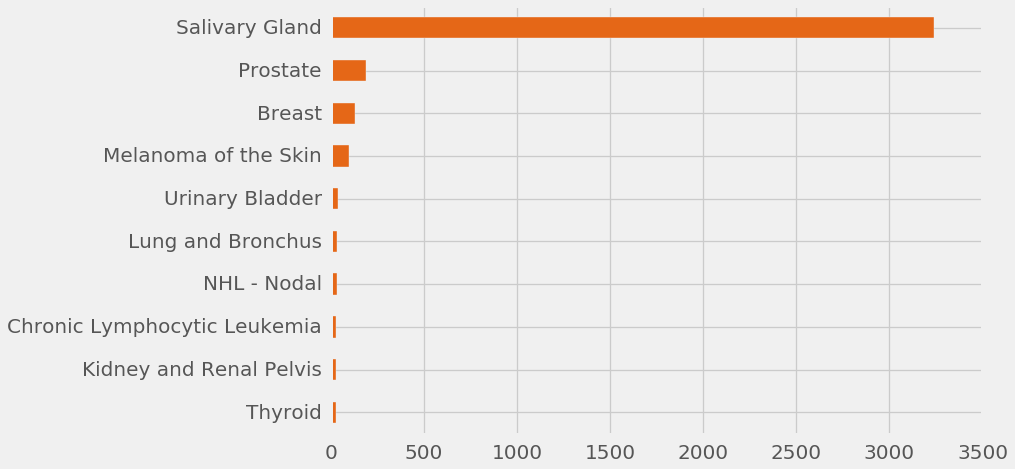

In [26]:
df2.siterwho1.value_counts()[:10][::-1].plot(kind='barh',
                                            color='#E56717');
plt.tick_params(labelsize=20)

# <font color="#E56717">Only keep those patients whose first tumor is at the site indicated in the corresponding file</font>

<span style="font-size:1.5em;">This way we avoid the complications other than the cancer under consideration that may be contributing factors to the outcomes we are analyzing.
Also restrict the analysis to those patients who received some form of radiation treatment for this first diagnosis as indicated by the SEER data.</span>

In [27]:
dfall.patient_id.isin(treatmentindices).sum()

1605

In [28]:
dfall.patient_id.isin(purecontrolindices).sum()

175878

In [29]:
dfall.shape

(719821, 496)

In [30]:
non_rad1 = dfall.rad1.str.contains('None',case=False,na=False)
refused_rad1 = dfall.rad1.str.contains('refused',case=False,na=False)
unknown_rad1 = dfall.rad1.str.contains('unknown',case=False,na=False)

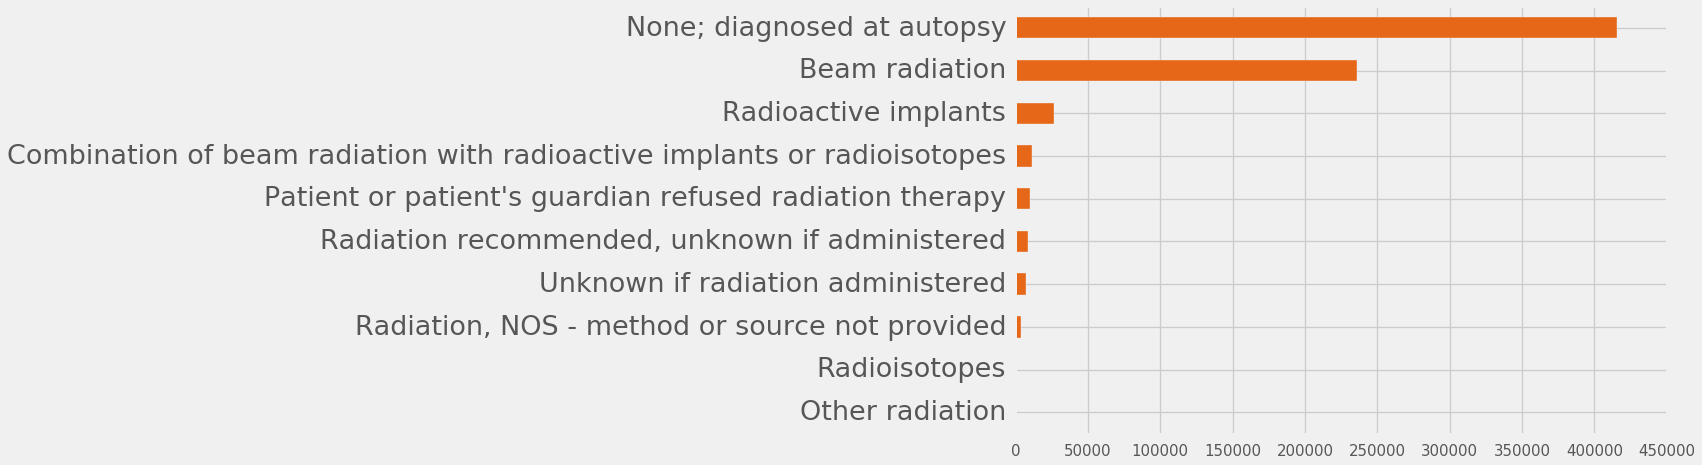

In [31]:
import mpld3
mpld3.disable_notebook()
ax = dfall.rad1.value_counts()[::-1].plot(kind='barh',color='#E56717')
ax.yaxis.set_tick_params(labelsize=27)
ax.xaxis.set_tick_params(labelsize=15)
#plt.tick_params(labelsize=27) # remove the None, refused and unknown group

In [32]:
one = ~non_rad1 & ~refused_rad1 & ~unknown_rad1

had_rad = one

dfsmall = dfall[had_rad].copy()



In [33]:
dfsmall.shape

(278330, 496)

In [34]:
smalltreatmentindices = dfsmall[dfsmall.patient_id.isin(treatmentindices)].index
smallcontrolindices = dfsmall[dfsmall.patient_id.isin(purecontrolindices)].index

In [35]:
smallcontrolindices.shape

(131038,)

In [36]:
smalltreatmentindices.shape


(1200,)

In [37]:
dfalltreatment = dfsmall.loc[smalltreatmentindices].copy()
dfallcontrol = dfsmall.loc[smallcontrolindices].copy()

In [38]:
dfalltreatment.shape, dfallcontrol.shape

((1200, 496), (131038, 496))

# <font color="#E56717">So we are going to match patients who have received PBT (1200 of them) with one of the 131038 patients who have received some other form of radiation. These patients have been identified as receiving RT treatment delivery in both halves of the SEER-Medicare data</font>

<span style="font-size:1.5em;">We first need to decide on which features (or columns) ofthe data to use to define the feature space; and then do some preprocessing of this data ("one-hot-encode" the categorical features)</span>

In [39]:
dfsmall.columns

Index(['casereg', 'patient_id', 'casenumber', 'fivepct', 'medicaredateofdeath',
       'birthm', 'birthyr', 'm_sex', 'race', 'state',
       ...
       'icdot09_1_description', 'icdot09_2_description',
       'icdot09_3_description', 'icdot09_4_description',
       'icdot09_5_description', 'icdot09_6_description',
       'icdot09_7_description', 'icdot09_8_description',
       'icdot09_9_description', 'icdot09_10_description'],
      dtype='object', length=496)

In [40]:
cstum1mask =  (dfsmall['cstum1'] != "Unknown; size not stated; not stated in patient record") & \
(dfsmall['cstum1'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfsmall['cstum1'] != "989 millimeters or larger") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != "Unknown age") & \
(dfsmall['cstum1'] != "Described as less than 1 cm") & \
(dfsmall['cstum1'] != "Described as less than 2 cm") & \
(dfsmall['cstum1'] != "Described as less than 3 cm") & \
(dfsmall['cstum1'] != 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfsmall['cstum1'] != "Described as less than 4 cm") & \
(dfsmall['cstum1'] != "Described as less than 5 cm") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != 'Not applicable') & \
(dfsmall['cstum1'] != 996) & \
(dfsmall['cstum1'] != 997) & \
(dfsmall['cstum1'] != 998) & \
(dfsmall['srvm1'] != 9999)

# <font color="#E56717">We will not include the variable **cstum1** (the tumor size in mm) for the following reasons:</font>

* <span style="font-size:1.5em;">Egregious measurement error, plots to follow for lung and prostate</span>
* <span style="font-size:1.5em;">Over half of the patients hav emissing values, or text values instead of numbers
    * "Unknown; size not stated; not stated in patient record"
    * "Microscopic focus or foci only; no size of focus is given"
    * "989 millimeters or larger"
    * "Not applicable"
    * "Described as less than 1 cm"
    * "Described as less than 2 cm"
    * "Described as less than 3 cm"
    * 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized'
    * "Described as less than 4 cm"
    * "Described as less than 5 cm"</span>

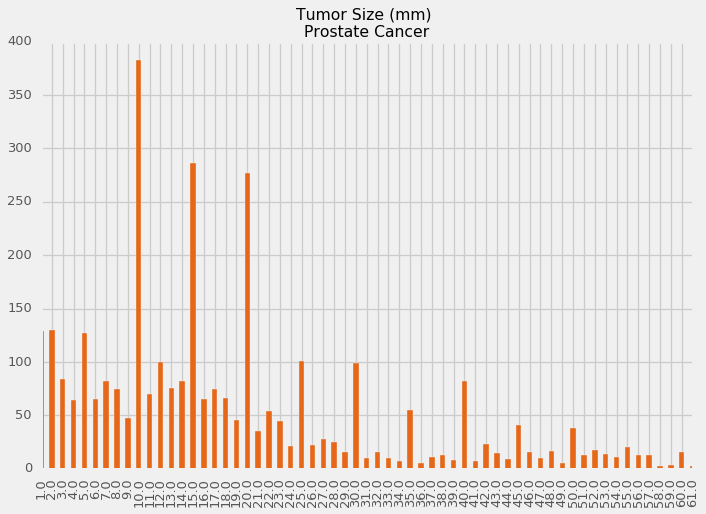

In [41]:
dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("prostate",case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nProstate Cancer',color='#E56717');
plt.xlim(0,60);

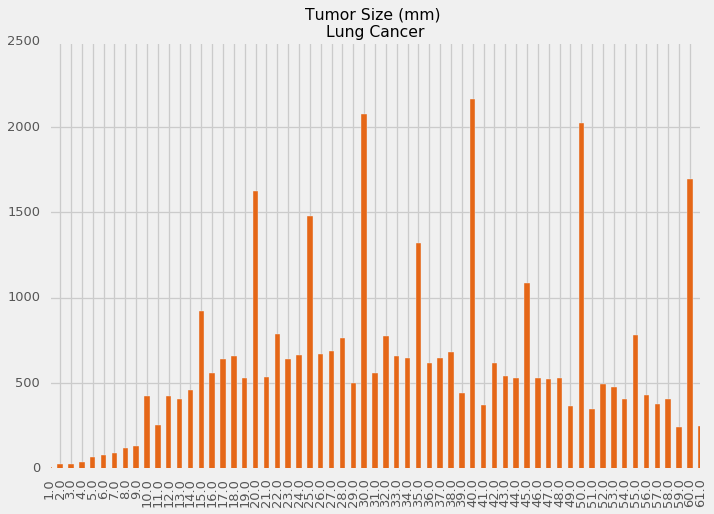

In [42]:
fig1 = plt.figure()
ax = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("lung",case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nLung Cancer',color='#E56717');
plt.xlim(0,60);

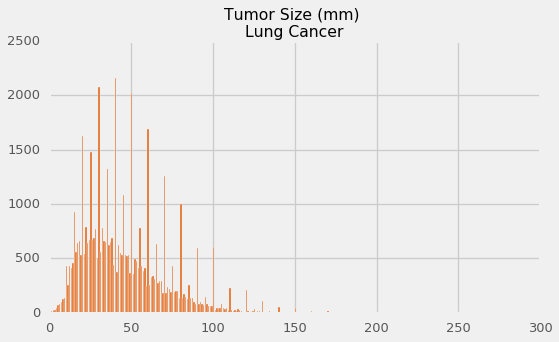

In [43]:
import mpld3
fig, ax = plt.subplots(figsize=(8,5))
huh = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("lung",case=False,na=False)].cstum1.value_counts().sort_index()
xvalues = huh.index
yvalues = huh.values

rects = ax.bar(xvalues,yvalues,color='#E56717')
plt.xlim(0,300)
plt.title('Tumor Size (mm) \nLung Cancer')
plt.tight_layout()
plt.show()

In [44]:
mpld3.disable_notebook()
mpld3.display(fig)

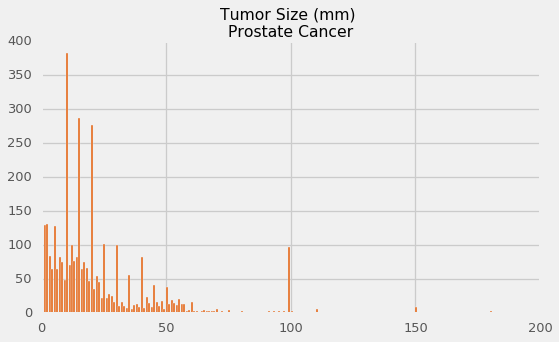

In [45]:
figp, ax = plt.subplots(figsize=(8,5))
huh = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("prostate",case=False,na=False)].cstum1.value_counts().sort_index()
xvalues = huh.index
yvalues = huh.values

rects = ax.bar(xvalues,yvalues,color='#E56717')
plt.xlim(0,200)
plt.title("Tumor Size (mm) \nProstate Cancer")
plt.tight_layout()
plt.show()

In [46]:
mpld3.display(figp)

# <font color="#E56717">This phenomena is so common (incluidng in medicine) it has a name</font>

## End-digit preference

<span style="font-size:1.5em;">"In converting analog to digital data, observers may record some terminal digits with an unusual frequency, for example rounding off may be to the nearest whole number, even number, multiple of 5 or 10, or when time units like a week are involved, 7, 14, etc."</span>

* <span style="font-size:1.2em;">Encyclopedia of Epidemiologic Methods, by By Mitchell H. Gail, Jacques Benichou</span>

In [76]:
catcols = ['m_sex','marst1','srace','nhiade','grade1',
           'site1','lat1',
          'histrec1',
           'modx1','stat_rec']


goodcols = ['m_sex','marst1', 'srace','nhiade',
           'grade1','site1',
           'lat1','histrec1',
           'modx1','stat_rec','birthyr',
           'agedx1',
           'yrdx1','elevation_1',
           'lng_1','lat_1']

In [77]:
dfpop = pd.concat([dfallcontrol, dfalltreatment])


In [78]:
resgoodcontrol = pd.concat([pd.get_dummies(dfallcontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfalltreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

In [79]:
print(goodcols)

['m_sex', 'marst1', 'srace', 'nhiade', 'grade1', 'site1', 'lat1', 'histrec1', 'modx1', 'stat_rec', 'birthyr', 'agedx1', 'yrdx1', 'elevation_1', 'lng_1', 'lat_1']


In [80]:
resgoodcontrol['birthyr'] = dfallcontrol['birthyr']
resgoodcontrol['agedx1'] = dfallcontrol['agedx1']

resgoodcontrol['yrdx1'] = dfallcontrol['yrdx1']


resgoodcontrol['lat_1'] = dfallcontrol['lat_1']

resgoodcontrol['lng_1'] = dfallcontrol['lng_1']

resgoodcontrol['srvm1'] = dfallcontrol['srvm1']

resgoodcontrol['elevation_1'] = dfallcontrol['elevation_1']

In [81]:
resgoodtreatment['birthyr'] = dfalltreatment['birthyr']
resgoodtreatment['agedx1'] = dfalltreatment['agedx1']

resgoodtreatment['yrdx1'] = dfalltreatment['yrdx1']


resgoodtreatment['lat_1'] = dfalltreatment['lat_1']

resgoodtreatment['lng_1'] = dfalltreatment['lng_1']

resgoodtreatment['srvm1'] = dfalltreatment['srvm1']

resgoodtreatment['elevation_1'] = dfalltreatment['elevation_1']

In [82]:
resgoodpop['birthyr'] = dfpop['birthyr']
resgoodpop['agedx1'] = dfpop['agedx1']

resgoodpop['yrdx1'] = dfpop['yrdx1']




resgoodpop['lat_1'] = dfpop['lat_1']

resgoodpop['lng_1'] = dfpop['lng_1']

resgoodpop['srvm1'] = dfpop['srvm1']

resgoodpop['elevation_1'] = dfpop['elevation_1']

# <font color="#E56717">After performing the matching between the control and treatment groups, we can see how the Kaplan-Meier curves differ</font>

<span style="font-size:1.5em;">Below is how it looks before matching patients in the control and treatment groups together in pairs</span>

In [83]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[smallcontrolindices]["srvm1"]
Econtrol = resgoodpop.loc[smallcontrolindices]["stat_rec_Dead"]

Ttreatment = resgoodpop.loc[smalltreatmentindices]["srvm1"]
Etreatment = resgoodpop.loc[smalltreatmentindices]["stat_rec_Dead"]

Tpop = resgoodpop["srvm1"]
Epop = resgoodpop["stat_rec_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All Radiation group');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='Non PBT group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='PBT group (treatment group)')

<lifelines.KaplanMeierFitter: fitted with 1200 observations, 1051 censored>

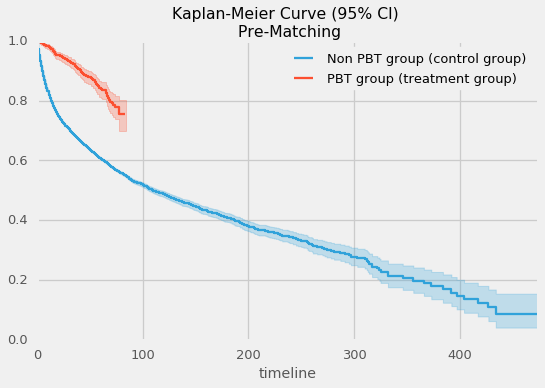

In [84]:
mpld3.enable_notebook()
ax = kmfcontrol.plot(figsize=(8,5))
kmftreatment.plot(ax=ax)
plt.title("Kaplan-Meier Curve (95% CI) \n Pre-Matching");

In [85]:
mpld3.disable_notebook()

# <font color="#E56717">Clearly, there is a difference between these survival curves</font>

<span style="font-size:1.5em;">But one can argue that we are not really comparing apples to apples when we calculate these two survival curves. To answer this objection, we need to perform patient matching, so that we are really comparing apples to apples and that any marked difference in the survival curves can be confidently attributed to the difference in treatment modalites.</span>

In [86]:
resgoodpop['birthyr'] = resgoodpop['birthyr'].astype('int')
resgoodpop['agedx1'] = resgoodpop['agedx1'].astype('float')



resgoodpop['lat_1'] = resgoodpop['lat_1'].astype('float')



resgoodpop['lng_1'] = resgoodpop['lng_1'].astype('float')
resgoodpop['elevation_1'] = resgoodpop['elevation_1'].astype('float')

resgoodpop['srvm1'] = resgoodpop['srvm1'].astype('float')


newcolumns = list(resgoodpop.columns)

newcolumns.remove('srvm1')
newcolumns.remove('stat_rec_Alive')
newcolumns.remove('stat_rec_Dead')
newcolumns.remove('m_sex_Male')

resgreatpop = resgoodpop[newcolumns].copy()

In [87]:
resgreatpop['patient_id'] = resgreatpop.index
leaguefilter = (resgreatpop['patient_id'].loc[smalltreatmentindices])
resgreatpop['League'] = resgreatpop['patient_id'].isin(smalltreatmentindices).astype('int')
del resgreatpop['patient_id']
dftree = resgreatpop.copy()

y = dftree['League'].copy()
del dftree['League']

In [88]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

In [89]:
print(list(dftree.columns))

['m_sex_Female', 'marst1_Divorced', 'marst1_Married (including common law)', 'marst1_Separated', 'marst1_Single (never married)', 'marst1_Unknown', 'marst1_Unmarried or domesntic partner (same sex or opposite sex or unregistered)', 'marst1_Widowed', 'srace_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)', 'srace_Asian Indian', 'srace_Asian Indian or Pakistani, NOS', 'srace_Black', 'srace_Chamorran', 'srace_Chinese', 'srace_Fiji Islander', 'srace_Filipino', 'srace_Guamanian, NOS', 'srace_Hawaiian', 'srace_Hmong', 'srace_Japanese', 'srace_Kampuchean (including Khmer and Cambodian)', 'srace_Korean', 'srace_Laotian', 'srace_Melanesian, NOS', 'srace_Micronesian, NOS', 'srace_New Guinean', 'srace_Other', 'srace_Other Asian, including Asian, NOS and Oriental NOS', 'srace_Pacific Islander, NOS', 'srace_Pakistani', 'srace_Polynesian, NOS', 'srace_Samoan', 'srace_Tahitian', 'srace_Thai', 'srace_Tongan', 'srace_Unknown', 'srace_Vi

<span style="font-size:1.5em;">This brute force method of finding similar patients in a high-dimensional space is possible thanks to a data structure called a KDTree. In order to construct the KDTree, we first need to transform the numeric data so that all of the different features contribute equally to the euclidean distance between patients/records. For example, agedx1 is on the order of 60 or so, while birthyr is around 1960. Without standardization, birthyr would contribute much more to the distance between patients than agedx1. The result of standardization (or z-score normalization) is that features will be rescaled so that they will have

$\mu = 0$ and $\sigma=1$

where $\mu$ is the mean and $\sigma$ is the standard deviation from the mean; z-scores are then calculated as follows:

$ z_{i} = \frac{x_{i} - \mu}{\sigma} $

In [90]:
dftree.shape

(132238, 194)

In [91]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
from sklearn.neighbors import KDTree
print(xTrain)

[[ 1.06007516 -0.31341832 -1.17459154 ...,  0.84981707  1.1889253
   0.20276887]
 [-0.94332933 -0.31341832  0.85135978 ...,  0.75238053  1.21271599
  -0.58449475]
 [-0.94332933 -0.31341832 -1.17459154 ...,  0.78270842  1.22939705
  -0.67116753]
 ..., 
 [ 1.06007516 -0.31341832  0.85135978 ..., -0.59655149 -0.98446674
   1.46075503]
 [ 1.06007516 -0.31341832  0.85135978 ..., -0.80965085 -1.03367113
   0.00463788]
 [ 1.06007516 -0.31341832  0.85135978 ..., -0.59655149 -0.98446674
   1.46075503]]


In [92]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)

# <font color="#E56717">Here is a video explaining the construction of a KDTree</font>

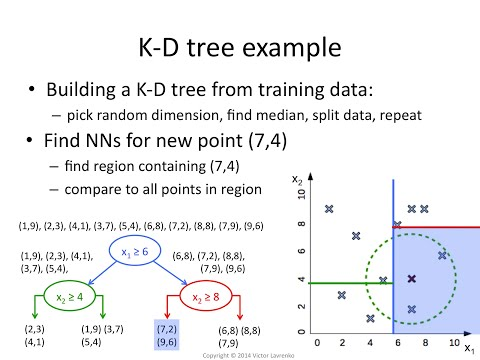

In [93]:
from IPython.display import YouTubeVideo
YouTubeVideo('Y4ZgLlDfKDg')

In [94]:
dftreeleague = dftree.copy()
dftreeleague['League'] = y

def get_league(x):
    return dftreeleague['League'].loc[x]

dist4, ind4 = kdt.query(xTrain, k=4, return_distance=True)

# <font color="#E56717">Finding the distance to all of the 4 nearest neighbors only took about 40 minutes</font>

In [95]:
dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)

dfmap = {v: dftreeleague.index[v] for v in range(dftreeleague.shape[0])}

In [96]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]


dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)

def get_league(x):
    return dftreeleague['League'].loc[x]

dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 0)

dist1filter = (dftreeleague['distance_1'] <= 2)
dist2filter = (dftreeleague['distance_2'] <= 2)
dist3filter = (dftreeleague['distance_3'] <= 2)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) & (dist1filter)].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 0)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) & (dist2filter)].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 0)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) & (dist3filter) ].copy()

one.head(10)

neighbor_1  distance_1  neighbor_1_League
patient_id                                           
8865019342  8882020381    0.630215                  0
4315229060  8792067479    1.547750                  0
4473112043  4408106073    0.564975                  0
8851092441  8841081424    1.830495                  0
8870085471  8835013250    1.688191                  0
8889005430  8848090384    1.045589                  0
0242402011  4296067064    1.368016                  0
0244410011  4208088055    1.010414                  0
0247485010  0209461001    1.928086                  0
0260460050  4405014841    1.181096                  0

In [97]:
onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict, threedict):
    for key, value in d.items():
        dd[key].append(value)
        
        

goodtreatmentteams = list(dd.keys())

goodcontrolteams = list(dd.values())
matches = list(set([item for sublist in goodcontrolteams for item in sublist]))

controlindices = matches
treatmentindices = goodtreatmentteams
print(len(treatmentindices))
print(len(controlindices))

973
2244


# <font color="#E56717">Need to do a one-to-one matching (where each member of the treatment group is matched to one and only one member of the control group, and where that matched control corresopnds to only one member of the treatment group</font>

In [98]:
d_one_to_one = {k: dd[k][0] for k in dd}
d_t_c = {}

for key, value in d_one_to_one.items():
    if value not in d_t_c.values():
        d_t_c[key] = value
        
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())    

In [99]:
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())

print(len(controlindices), len(treatmentindices))

916 916


<span style="font-size:1.8em;">So we have 916 treatment patients matched very closely to 916 control patients</span>

In [100]:
from lifelines import KaplanMeierFitter

#kmfpop = KaplanMeierFitter()
kmfcontrolpost = KaplanMeierFitter()
kmftreatmentpost = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srvm1"]
Econtrol = resgoodpop.loc[controlindices]["stat_rec_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srvm1"]
Etreatment = resgoodpop.loc[treatmentindices]["stat_rec_Dead"]

Tpop = resgoodpop["srvm1"]
Epop = resgoodpop["stat_rec_Dead"]

#kmfpop.fit(Tpop, event_observed=Epop,label='All Nasopharynx');
kmfcontrolpost.fit(Tcontrol, event_observed=Econtrol,label='No PBT Group (control group; post-matching)')
kmftreatmentpost.fit(Ttreatment, event_observed=Etreatment, label='PBT Group (treatment group; post-matching)')
#ax = kmfpop.plot()
###ax = kmfcontrol.plot()
###kmftreatment.plot(ax=ax)
###plt.title("Nasopharynx Kaplan-Meier Curve (95% CI) \n Post-Matching");

<lifelines.KaplanMeierFitter: fitted with 916 observations, 833 censored>

# <font color="#E56717">Now here is the Kaplan-Meier plot of the post-matching treatment and control groups</font>

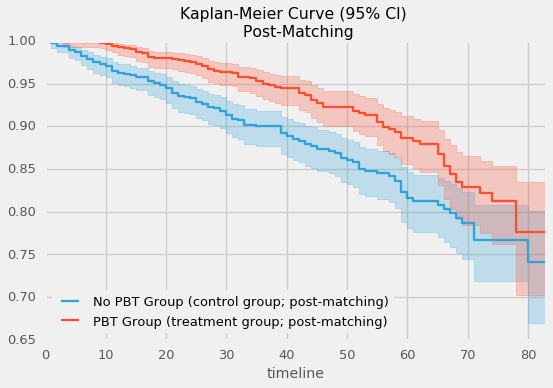

In [101]:
mpld3.enable_notebook()
ax = kmfcontrolpost.plot(figsize=(8,5))
kmftreatmentpost.plot(ax=ax)
plt.title("Kaplan-Meier Curve (95% CI) \n Post-Matching");

# <font color="#E56717">We can perform a rigorous test to see if the two survival curves truly have different DGPs (data generation processes)</font>

In [102]:
from lifelines.statistics import logrank_test
results = logrank_test(Ttreatment, Tcontrol, Etreatment, Econtrol)
results.print_summary()


Results
   alpha: 0.95
   t 0: -1
   df: 1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00054 |             11.981 |      Reject Null    |        True       


In [103]:
import pickle
fileObject = open('control_indicies.pickle','wb')
pickle.dump(controlindices, fileObject)
fileObject.close()

In [104]:
import pickle
fileObject = open('treatment_indicies.pickle','wb')
pickle.dump(treatmentindices, fileObject)
fileObject.close()

In [105]:
df = df.set_index('patient_id',drop=False)

# <font color="#E56717">Investigate the results of the matching</font>

# <font color="#E56717">Gender breakdown</font>

In [106]:
df['m_sex'][df['patient_id'].isin(treatmentindices)].value_counts()

Male      889
Female     27
Name: m_sex, dtype: int64

In [107]:
df['m_sex'][df['patient_id'].isin(controlindices)].value_counts()

Male      889
Female     27
Name: m_sex, dtype: int64

# <font color="#E56717">Marital status breakdown</font>

In [108]:
df['marst1'][df['patient_id'].isin(treatmentindices)].value_counts()

Married (including common law)    722
Divorced                           57
Single (never married)             52
Unknown                            42
Widowed                            38
Separated                           5
Name: marst1, dtype: int64

In [109]:
df['marst1'][df['patient_id'].isin(controlindices)].value_counts()

Married (including common law)    722
Divorced                           57
Single (never married)             52
Unknown                            42
Widowed                            38
Separated                           5
Name: marst1, dtype: int64

# <font color="#E56717">Racial breakdown</font>

In [110]:
df['srace'][df['patient_id'].isin(treatmentindices)].value_counts()

White                                                                                                                 840
Black                                                                                                                  41
Chinese                                                                                                                 9
Other Asian, including Asian, NOS and Oriental NOS                                                                      8
Filipino                                                                                                                7
Korean                                                                                                                  5
Japanese                                                                                                                5
American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)      1
Name: srace, dtype: int6

In [111]:
df['srace'][df['patient_id'].isin(controlindices)].value_counts()


White                                                                                                                 840
Black                                                                                                                  41
Chinese                                                                                                                 9
Other Asian, including Asian, NOS and Oriental NOS                                                                      8
Filipino                                                                                                                7
Korean                                                                                                                  5
Japanese                                                                                                                5
American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)      1
Name: srace, dtype: int6

# <font color="#E56717">nhiade breakdown</font>

In [112]:
df['nhiade'][df['patient_id'].isin(treatmentindices)].value_counts()

Non-Spanish-Hispanic-Latino                   866
Spanish/Hispanic/Latino, NOS                   30
Mexican                                         9
NHIA Surname Match Only                         7
South or Central American excluding Brazil      3
Cuban                                           1
Name: nhiade, dtype: int64

In [113]:

df['nhiade'][df['patient_id'].isin(controlindices)].value_counts()

Non-Spanish-Hispanic-Latino                   866
Spanish/Hispanic/Latino, NOS                   30
Mexican                                         9
NHIA Surname Match Only                         7
South or Central American excluding Brazil      3
Cuban                                           1
Name: nhiade, dtype: int64

# <font color="#E56717">Grade breakdown</font>

In [114]:
df['grade1'][df['patient_id'].isin(treatmentindices)].value_counts()

Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               481
Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    388
cell type not determined, not stated or not applicable                                                              40
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                  4
Grade IV; grade iv; grade 4; undifferentaited; anaplastic                                                            3
Name: grade1, dtype: int64

In [115]:
df['grade1'][df['patient_id'].isin(controlindices)].value_counts()

Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               481
Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    388
cell type not determined, not stated or not applicable                                                              40
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                  4
Grade IV; grade iv; grade 4; undifferentaited; anaplastic                                                            3
Name: grade1, dtype: int64

# <font color="#E56717">Site breakdown</font>

In [116]:
df['site1'][df['patient_id'].isin(treatmentindices)].value_counts()

Prostate gland                    857
Upper lobe, lung                   22
Choroid                            18
Lower lobe, lung                    5
Upper-outer quadrant of breast      3
Lower third of esophagus            2
Overlapping lesion of breast        2
Lower-inner quadrant of breast      2
Frontal lobe                        1
Temporal lobe                       1
Parotid gland                       1
Lung, NOS                           1
Parietal lobe                       1
Name: site1, dtype: int64

In [117]:
df['site1'][df['patient_id'].isin(controlindices)].value_counts()

Prostate gland                    857
Upper lobe, lung                   22
Choroid                            18
Lower lobe, lung                    5
Upper-outer quadrant of breast      3
Lower third of esophagus            2
Overlapping lesion of breast        2
Lower-inner quadrant of breast      2
Frontal lobe                        1
Temporal lobe                       1
Parotid gland                       1
Lung, NOS                           1
Parietal lobe                       1
Name: site1, dtype: int64

# <font color="#E56717">Histology breakdown</font>

In [118]:
df['histrec1'][df['patient_id'].isin(treatmentindices)].value_counts()


8140-8398: adenomas and adenocarcinomas    867
8720-8799: nevi and melanomas               18
8010-8049: epithelial neplasms, NOS         10
8050-8089: squamous cell neplasms            9
8500-8549: ductal and lobular neoplasms      7
9380-9489: gliomas                           3
8560-8579: complex epithelial neoplasms      1
8550-8559: acinar cell neoplasms             1
Name: histrec1, dtype: int64

In [119]:
df['histrec1'][df['patient_id'].isin(controlindices)].value_counts()

8140-8398: adenomas and adenocarcinomas    867
8720-8799: nevi and melanomas               18
8010-8049: epithelial neplasms, NOS         10
8050-8089: squamous cell neplasms            9
8500-8549: ductal and lobular neoplasms      7
9380-9489: gliomas                           3
8560-8579: complex epithelial neoplasms      1
8550-8559: acinar cell neoplasms             1
Name: histrec1, dtype: int64

# <font color="#E56717">Month of diagnosis breakdown</font>

In [120]:
df['modx1'][df['patient_id'].isin(treatmentindices)].value_counts()

Mar    85
Aug    84
Jun    84
Feb    83
Jul    81
Jan    79
May    77
Oct    76
Nov    73
Apr    72
Sep    66
Dec    53
Name: modx1, dtype: int64

In [121]:
df['modx1'][df['patient_id'].isin(controlindices)].value_counts()

Mar    85
Aug    84
Jun    84
Feb    83
Jul    81
Jan    79
May    77
Oct    76
Nov    73
Apr    72
Sep    66
Dec    53
Name: modx1, dtype: int64

# <font color="#E56717">birthyr breakdown</font>

In [122]:

df['birthyr'][df['patient_id'].isin(treatmentindices)].describe()

count     916.000000
mean     1937.031659
std         5.625671
min      1918.000000
25%      1934.000000
50%      1938.000000
75%      1941.000000
max      1957.000000
Name: birthyr, dtype: float64

In [123]:
df['birthyr'][df['patient_id'].isin(controlindices)].describe()

count     916.000000
mean     1936.842795
std         5.267839
min      1920.000000
25%      1933.000000
50%      1937.000000
75%      1941.000000
max      1953.000000
Name: birthyr, dtype: float64

# <font color="#E56717">Age at diagnosis breakdown</font>

In [124]:
df['agedx1'][df['patient_id'].isin(treatmentindices)].describe()

count    916.000000
mean      70.922489
std        5.373635
min       53.000000
25%       67.000000
50%       70.000000
75%       74.000000
max       89.000000
Name: agedx1, dtype: float64

In [125]:
df['agedx2'][df['patient_id'].isin(controlindices)].describe()

count    65.000000
mean     73.476923
std       5.256269
min      63.000000
25%      69.000000
50%      73.000000
75%      77.000000
max      86.000000
Name: agedx2, dtype: float64

# <font color="#E56717">Laterality breakdown</font>

In [126]:
df['lat1'][df['patient_id'].isin(treatmentindices)].value_counts()

Not a paired site                                                       859
Right: origin of primary                                                 32
Left: origin of primary                                                  24
Paired site, but no information concerning laterality; midline tumor      1
Name: lat1, dtype: int64

In [127]:
df['lat1'][df['patient_id'].isin(controlindices)].value_counts()

Not a paired site                                                       859
Right: origin of primary                                                 32
Left: origin of primary                                                  24
Paired site, but no information concerning laterality; midline tumor      1
Name: lat1, dtype: int64

# <font color="#E56717">latitude breakdown</font>

In [128]:
df['lat_1'][df['patient_id'].isin(treatmentindices)].astype('float').describe()

count    916.000000
mean      35.870484
std        3.131846
min       21.306986
25%       33.953297
50%       34.959208
75%       37.948809
max       48.611804
Name: lat_1, dtype: float64

In [129]:
df['lat_1'][df['patient_id'].isin(controlindices)].astype('float').describe()

count    916.000000
mean      36.053560
std        3.124011
min       21.306986
25%       33.953297
50%       34.959208
75%       37.853409
max       48.611804
Name: lat_1, dtype: float64

# <font color="#E56717">Longitude breakdown</font>

In [130]:
df['lng_1'][df['patient_id'].isin(treatmentindices)].astype('float').describe()

count    916.000000
mean    -113.205388
std       13.759900
min     -157.858432
25%     -119.698206
50%     -117.396119
75%     -116.419389
max      -72.046816
Name: lng_1, dtype: float64

In [131]:

df['lng_1'][df['patient_id'].isin(controlindices)].astype('float').describe()

count    916.000000
mean    -113.038286
std       14.048292
min     -157.858432
25%     -120.987632
50%     -118.243660
75%     -116.419389
max      -72.046816
Name: lng_1, dtype: float64

# <font color="#E56717">Elevation breakdown</font>

In [132]:

df['elevation'][df['patient_id'].isin(treatmentindices)].astype('float').describe()

count      916.000000
mean      1213.957872
std       1475.928956
min       -199.678057
25%         94.745456
50%        827.483657
75%       1561.999233
max      10069.186315
Name: elevation, dtype: float64

In [133]:
df['elevation'][df['patient_id'].isin(controlindices)].astype('float').describe()

count      916.000000
mean      1131.699613
std       1462.893440
min       -199.678057
25%        150.117353
50%        713.249840
75%       1419.385520
max      10616.362503
Name: elevation, dtype: float64

# <font color="#E56717">Are PBT or conventional RT patients more likely to eperience secondary malignancies?</font>

In [134]:

print(df['agedx2'].loc[controlindices].value_counts().sum(), df['agedx2'].loc[controlindices].shape)

65 (916,)


In [135]:
print(df['agedx2'].loc[treatmentindices].value_counts().sum(), df['agedx2'].loc[treatmentindices].shape)

47 (916,)


# <font color="#E56717">So 65 out of 916 control patients had a second primary tumor, while 47 out of 916 PBT patients had a second primary tumor.</font>

In [136]:
df['modx1'].head()


patient_id
0205455031    Jun
0208413011    Dec
0208497001    Nov
0212443031    Sep
0212448031    Aug
Name: modx1, dtype: object

In [137]:

monthdict = {'Jan': '01',
            'Feb': '02',
            'Mar': '03',
            'Apr': '04',
            'May': '05',
            'Jun': '06',
            'Jul': '07',
            'Aug': '08',
            'Sep': '09',
            'Oct': '10',
            'Nov': '11',
            'Dec': '12'}

In [138]:
df['month1'] = df['modx1'].replace(monthdict)

In [139]:
df['modx2'] = df['modx2'].replace(monthdict)

In [140]:
df['datedx1'] = df.yrdx1.astype('str') + df.month1.astype('str')

df['datedx1'] = pd.to_datetime(df['datedx1'][df['month1'].notnull()], 
                                                      format='%Y%m')

In [141]:
df['datedx2'] = df.yrdx2.astype('str').str.replace('\.0','') + df.modx2.astype('str')

In [146]:
df['datedx2'] = pd.to_datetime(df['datedx2'][~df['datedx2'].str.contains('nan',case=False,na=False)], 
                                                     format='%Y%m')

In [147]:
dffollowupcontrol = df[['datedx1','datedx2','srvm1']].loc[controlindices].copy()

dffollowuptreatment = df[['datedx1','datedx2','srvm1']].loc[treatmentindices].copy()

In [148]:
df[['datedx1','datedx2','srvm1']].loc[controlindices].head()

datedx1 datedx2  srvm1
patient_id                          
8860098430 2009-12-01     NaT     34
8824011431 2010-12-01     NaT     24
8805039373 2007-01-01     NaT     69
8771033409 2008-02-01     NaT     58
4460133094 2009-10-01     NaT      6

In [149]:
def make_months(i):
    if i.value != -9223372036854775808:
        return i.days/30
    else:
        return i

In [150]:
dffollowupcontrol['delta'] = pd.to_timedelta(dffollowupcontrol['datedx2'] - dffollowupcontrol['datedx1'],unit='m')

dffollowuptreatment['delta'] = pd.to_timedelta(dffollowuptreatment['datedx2'] - dffollowuptreatment['datedx1'],unit='m')


dffollowupcontrol['delta_months'] = dffollowupcontrol.delta.apply(make_months)

dffollowuptreatment['delta_months'] = dffollowuptreatment.delta.apply(make_months).astype('object')

In [151]:
from dateutil import relativedelta

In [152]:
dffollowupcontrol.head()

datedx1 datedx2  srvm1  delta delta_months
patient_id                                              
8860098430 2009-12-01     NaT     34    NaT          NaT
8824011431 2010-12-01     NaT     24    NaT          NaT
8805039373 2007-01-01     NaT     69    NaT          NaT
8771033409 2008-02-01     NaT     58    NaT          NaT
4460133094 2009-10-01     NaT      6    NaT          NaT

In [153]:
dffollowupcontrol['followup_months'] = dffollowupcontrol['delta_months'].fillna(dffollowupcontrol.srvm1)

In [154]:
dffollowupcontrol.head()

datedx1 datedx2  srvm1  delta delta_months  \
patient_id                                                 
8860098430 2009-12-01     NaT     34    NaT          NaT   
8824011431 2010-12-01     NaT     24    NaT          NaT   
8805039373 2007-01-01     NaT     69    NaT          NaT   
8771033409 2008-02-01     NaT     58    NaT          NaT   
4460133094 2009-10-01     NaT      6    NaT          NaT   

                         followup_months  
patient_id                                
8860098430 1970-01-01 00:00:00.000000034  
8824011431 1970-01-01 00:00:00.000000024  
8805039373 1970-01-01 00:00:00.000000069  
8771033409 1970-01-01 00:00:00.000000058  
4460133094 1970-01-01 00:00:00.000000006

In [155]:
dffollowuptreatment['followup_months'] = dffollowuptreatment['delta_months'].fillna(dffollowuptreatment.srvm1)

In [156]:

def make_months_treatment(i):
    try:
        return int(i.days/30)
    except:
        return i

In [157]:
dffollowuptreatment.head()

datedx1 datedx2  srvm1  delta delta_months followup_months
patient_id                                                              
8813084410 2009-12-01     NaT     36    NaT          NaT              36
8831093492 2010-12-01     NaT     24    NaT          NaT              24
8832098311 2007-01-01     NaT     69    NaT          NaT              69
8785044459 2008-02-01     NaT     58    NaT          NaT              58
4454195034 2009-10-01     NaT     37    NaT          NaT              37

In [158]:
delta_months = dffollowuptreatment[dffollowuptreatment.delta.notnull()].delta.apply(make_months_treatment)
dffollowuptreatment['delta_months'] = delta_months
dffollowuptreatment['followup_months'] = dffollowuptreatment['delta_months'].fillna(dffollowuptreatment.srvm1)
dffollowuptreatment[dffollowuptreatment.delta.notnull()]

datedx1    datedx2  srvm1     delta  delta_months  \
patient_id                                                        
8881097352 2007-12-01 2008-05-01     60  152 days           5.0   
8828070323 2007-04-01 2010-09-01     42 1249 days          41.0   
8825009174 2008-07-01 2008-12-01     53  153 days           5.0   
8832083395 2009-06-01 2009-09-01     42   92 days           3.0   
8815003350 2006-03-01 2011-09-01     81 2010 days          67.0   
8807088311 2006-08-01 2007-11-01     76  457 days          15.0   
8887005322 2007-09-01 2009-11-01     38  792 days          26.0   
8830065394 2008-03-01 2009-05-01     57  426 days          14.0   
8866014452 2011-01-01 2011-03-01     23   59 days           1.0   
8847037351 2006-10-01 2012-04-01     66 2009 days          66.0   
8832086361 2006-08-01 2007-03-01     65  212 days           7.0   
8841024470 2010-04-01 2012-06-01     33  792 days          26.0   
8847038351 2006-09-01 2009-01-01     66  853 days          28.0   
8876003300 2006-10-01 2012-02-01     74 1949 days          64.0   
8850024395 2008-07-01 2009-09-01     32  427 days          14.0   
8848090352 2007-04-01 2010-09-01     68 1249 days          41.0   
2557043065 2006-05-01 2011-11-01     79 2010 days          67.0   
4308103100 2008-03-01 2010-06-01     57  822 days          27.0   
8802015104 2006-02-01 2011-11-01     78 2099 days          69.0   
8837091492 2011-04-01 2011-12-01     20  244 days           8.0   
2583016095 2007-04-01 2012-08-01     65 1949 days          64.0   
4305233040 2008-07-01 2008-07-01     12    0 days           0.0   
8825058106 2008-02-01 2008-04-01     39   60 days           2.0   
8855034350 2006-01-01 2007-03-01     83  424 days          14.0   
8812022354 2008-01-01 2012-12-01     59 1796 days          59.0   
8867093432 2011-03-01 2011-06-01     21   92 days           3.0   
8866047333 2008-05-01 2010-10-01     55  883 days          29.0   
8875067360 2006-08-01 2008-08-01     51  731 days          24.0   
8802055392 2007-02-01 2008-12-01     70  669 days          22.0   
8829091395 2009-04-01 2011-10-01     44  913 days          30.0   
...               ...        ...    ...       ...           ...   
8812011384 2008-07-01 2010-08-01     53  761 days          25.0   
2338115040 2006-02-01 2011-08-01     68 2007 days          66.0   
8880017354 2009-02-01 2010-11-01     46  638 days          21.0   
8825009364 2009-10-01 2011-08-01     26  669 days          22.0   
8820017411 2010-01-01 2011-11-01     35  669 days          22.0   
2514038016 2008-07-01 2010-08-01     53  761 days          25.0   
8867069351 2007-03-01 2007-06-01     69   92 days           3.0   
8881009431 2010-11-01 2012-08-01     25  639 days          21.0   
8820061351 2006-11-01 2006-12-01     73   30 days           1.0   
8852008384 2008-12-01 2010-09-01     48  639 days          21.0   
8841059364 2008-10-01 2012-04-01     44 1278 days          42.0   
4356288030 2010-05-01 2011-10-01     17  518 days          17.0   
8846080335 2009-06-01 2012-01-01     42  944 days          31.0   
8852031362 2007-09-01 2008-07-01     13  304 days          10.0   
8882010432 2011-06-01 2011-07-01     19   30 days           1.0   
8876031350 2006-07-01 2009-06-01     57 1066 days          35.0   
8836027335 2009-09-01 2011-06-01     24  638 days          21.0   
8879029321 2006-10-01 2012-09-01     74 2162 days          72.0   
8829031362 2007-03-01 2012-09-01     67 2011 days          67.0   
8810023332 2007-03-01 2009-03-01     68  731 days          24.0   
4436175014 2009-05-01 2010-08-01     31  457 days          15.0   
8892015422 2011-06-01 2012-03-01     18  274 days           9.0   
8819068381 2006-08-01 2008-06-01     76  670 days          22.0   
8809039392 2007-02-01 2012-04-01     70 1886 days          62.0   
8897051314 2009-06-01 2010-06-01     42  365 days          12.0   
8878081393 2008-10-01 2010-02-01     50  488 days          16.0   
8795009438 2007-02-01 2012-01-01     70 1795 days          59

In [162]:
delta_months = dffollowupcontrol[dffollowupcontrol.delta.notnull()].delta.apply(make_months_treatment)
dffollowupcontrol['delta_months'] = delta_months
dffollowupcontrol['followup_months'] = dffollowupcontrol['delta_months'].fillna(dffollowupcontrol.srvm1)
dffollowupcontrol[dffollowupcontrol.delta.notnull()]

datedx1    datedx2  srvm1      delta  delta_months  \
patient_id                                                         
8824058385 2008-02-01 2009-06-01     22   486 days          16.0   
8728085530 2010-02-01 2012-09-01     34   943 days          31.0   
8856058324 2008-03-01 2009-03-01     12   365 days          12.0   
8824062394 2008-12-01 2012-04-01     48  1217 days          40.0   
8803065343 2007-01-01 2011-05-01     71  1581 days          52.0   
8842038320 2006-05-01 2009-02-01     79  1007 days          33.0   
8845071383 2007-11-01 2012-06-01     60  1674 days          55.0   
4312233010 2008-11-01 2009-04-01     26   151 days           5.0   
8872025300 2006-08-01 2011-06-01     59  1765 days          58.0   
8872059481 2011-04-01 2011-06-01     20    61 days           2.0   
8885072342 2007-07-01 2007-08-01     65    31 days           1.0   
8845017311 2006-10-01 2007-01-01     31    92 days           3.0   
8826020441 2010-03-01 2012-11-01     33   976 days          32.0   
8774084459 2008-10-01 2010-09-01     50   700 days          23.0   
8847044371 2006-08-01 2011-06-01     71  1765 days          58.0   
8816062363 2007-10-01 2009-08-01     24   670 days          22.0   
4300179310 2008-03-01 2009-01-01     11   306 days          10.0   
8780021419 2008-10-01 2011-05-01     30   942 days          31.0   
2618018013 2010-10-01 2011-07-01     17   273 days           9.0   
8894052320 2006-08-01 2009-07-01     35  1065 days          35.0   
2600043093 2010-03-01 2011-02-01     33   337 days          11.0   
8894045441 2010-10-01 2012-07-01     26   639 days          21.0   
8849097420 2010-03-01 2009-12-01     33   -90 days          -3.0   
8855046344 2009-02-01 2009-03-01     46    28 days           0.0   
8863055300 2006-06-01 2009-05-01     78  1065 days          35.0   
2536080037 2011-03-01 2011-04-01     21    31 days           1.0   
8816064450 2009-08-01 2011-02-01     27   549 days          18.0   
8827062375 2009-05-01 2010-07-01     43   426 days          14.0   
8877072344 2008-12-01 2011-06-01     33   912 days          30.0   
8817038353 2008-04-01 2012-12-01     56  1705 days          56.0   
...               ...        ...    ...        ...           ...   
2557085075 2006-06-01 2006-06-01     78     0 days           0.0   
8703040429 2007-03-01 2007-04-01      4    31 days           1.0   
8808024403 2010-11-01 2012-09-01     22   670 days          22.0   
8865071350 2006-08-01 2009-01-01     72   884 days          29.0   
8864080315 2009-03-01 2011-02-01     45   702 days          23.0   
8821021310 2006-02-01 2011-04-01     80  1885 days          62.0   
8808034392 2007-04-01 2009-09-01     29   884 days          29.0   
2655038072 2007-04-01 2008-11-01     43   580 days          19.0   
4296040043 2007-11-01 2010-01-01     25   792 days          26.0   
8891081300 2006-04-01 2009-01-01     78  1006 days          33.0   
4422191074 2008-05-01 2009-11-01     18   549 days          18.0   
8823012363 2008-01-01 2008-10-01     57   274 days           9.0   
8807036400 2007-10-01 2011-04-01     60  1278 days          42.0   
4268056083 2006-11-01 2011-01-01     73  1522 days          50.0   
8844096383 2008-01-01 2012-06-01     59  1613 days          53.0   
2656029012 2006-03-01 2008-10-01     81   945 days          31.0   
8888053390 2006-03-01 2009-05-01     50  1157 days          38.0   
0235483020 2006-05-01 2009-08-01     59  1188 days          39.0   
8847035390 2006-05-01 2010-12-01     77  1675 days          55.0   
2078111058 2008-09-01 2009-11-01     51   426 days          14.0   
8832050314 2008-08-01 2010-12-01     52   852 days          28.0   
4463107085 2011-09-01 2012-01-01     15   122 days           4.0   
8872093380 2010-05-01 2006-07-01     31 -1400 days         -46.0   
8797073408 2007-02-01 2008-01-01     11   334 days          11.0   
8804011323 2007-08-01 2007-12-01      4   122 days           4.0   
8824036312 2007-02-01 2009-12-01     33  1034 days          34.0   
88

In [161]:
dffollowuptreatment.followup_months.mean()

43.86244541484716

In [163]:
dffollowupcontrol.followup_months.mean()

42.69213973799127

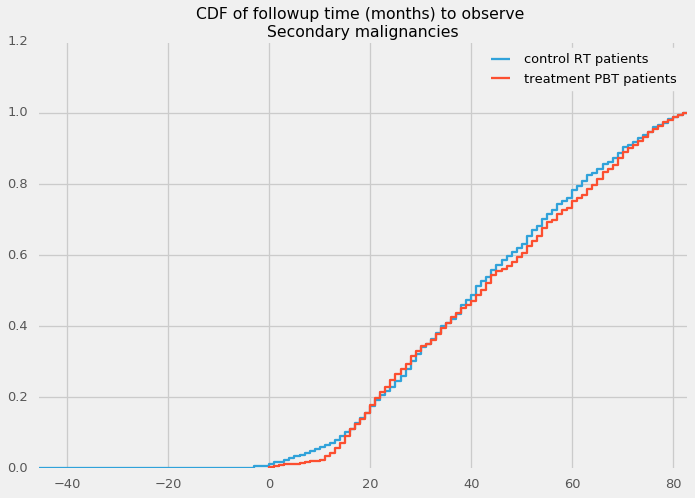

In [164]:
ax = dffollowupcontrol.followup_months.value_counts(normalize=True).sort_index().cumsum().plot(label='control RT patients',
                                                                            drawstyle='steps')
dffollowuptreatment.followup_months.value_counts(normalize=True).sort_index().cumsum().plot(drawstyle='steps',
                                                                                          ax=ax,
                                                                            label='treatment PBT patients')

plt.title("CDF of followup time (months) to observe \nSecondary malignancies");
plt.legend()

In [165]:
print(df['agedx2'].loc[controlindices].value_counts().sum(), df['agedx2'].loc[controlindices].shape)

65 (916,)


In [166]:
print(df['agedx2'].loc[treatmentindices].value_counts().sum(), df['agedx2'].loc[treatmentindices].shape)

47 (916,)


# <font color="#E56717">Assess the statistical significance of this difference with Bayesian A/B testing</font>

In [167]:
probcontrol = 65/916
probtreatment = 47/916
print(probcontrol,probtreatment)

0.07096069868995633 0.05131004366812227


In [168]:
controltotal = 916
treatmenttotal = 916
controlsecondary = 65
treatmentsecondary = 47

In [169]:
TREATMENT_SECONDARY = treatmentsecondary
CONTROL_SECONDARY = controlsecondary
TREATMENT_TOTAL = treatmenttotal
CONTROL_TOTAL = controltotal
from scipy.stats import beta
alpha_prior = 1
beta_prior = 1
posterior_treatment = beta(alpha_prior + TREATMENT_SECONDARY, beta_prior + TREATMENT_TOTAL - TREATMENT_SECONDARY)
posterior_control = beta(alpha_prior + CONTROL_SECONDARY, beta_prior + CONTROL_TOTAL - CONTROL_SECONDARY)
samples = 2000000
samples_posterior_treatment = posterior_treatment.rvs(samples)
samples_posterior_control = posterior_control.rvs(samples)
(samples_posterior_control > samples_posterior_treatment).mean()

0.95989449999999998

(0, 0.2)

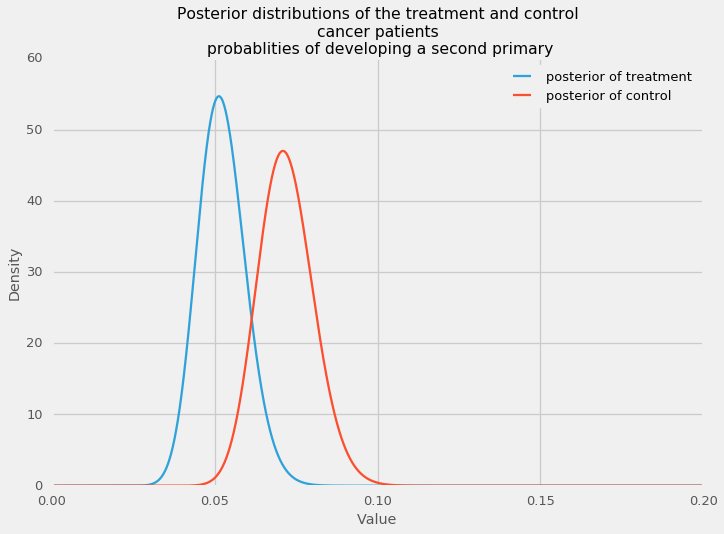

In [171]:
x = np.linspace(0,1, 50000)
plt.plot(x, posterior_treatment.pdf(x), label='posterior of treatment')
plt.plot(x, posterior_control.pdf(x), label='posterior of control');
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("""Posterior distributions of the treatment and control
cancer patients\n probablities of developing a second primary""")
plt.legend();
plt.xlim(0,.2)